Trump vs Biden 2020 Presidential Campaign Twitter Sentiment
Introduction
One of the hottest topics in 2020 was the presidential election between Donald J. Trump and former vice president Joe Biden. This election was full of firsts; It was the first election held during a worldwide pandemic, the first election to have 3 states whose margin of victory was under 1%, and the first incumbent president not to concede. Because of the election's uniqueness and the highly contrasting personalities between the candidates, I decided to analyze the sentiment of each candidate’s tweets to find out how much their social media attitude affected their twitter impressions and their general approval.

In the analysis, we mapped the candidate's sentiment in a time series as well as measured how popular their most liked and dislike tweets were through retweets and likes. We wanted to see if there was a correlation between negative or positive sentiment and popularity for each candidate.

We got the motivation for this topic from an article published by Cambridge University Press titled: “Differences in negativity bias underlie variations in political ideology”. This article discusses how negative thoughts gain more attention and popularity than positive thoughts do. Negative thoughts also stay within our memory for a longer period. This also links to negative bias in politics, which triggered an idea to apply sentiment analysis in politics. The 2020 presidential election was the perfect area to focus this analysis on negative political bias. TE

Note, get general approval data

April 25, 2019, Biden

Links:

https://www.scientificamerican.com/article/the-neuroscience-of-everybody-favorite-topic-themselves/

https://www.kaggle.com/rohanrao/joe-biden-tweets

https://www.kaggle.com/codebreaker619/donald-trump-tweets-dataset

https://www.kaggle.com/amineabouothmane/biden-vs-trump-sentiment-analysis-of-tweets

https://www.kaggle.com/ahmedterry/trump-tweets-eda-nlp-sentiments-analysis

https://www.kaggle.com/thomaskonstantin/trump-s-insults-time-based-sentiment-analysis

## Import Resources
### Libraries

In [2]:

import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from textblob import TextBlob
import datetime
import re

In [4]:
# dont run these 
# AccessToken = '1325166553-AaLqrAHSEzFQg0KOQPrfL5B46EiOuvw3bWV7FUb'
# AccessTokenSecret = 'ahA6V1c7wQoByveazFsq1dcf2YrqccUqbmlPuWCNUJ8Yo'
# API_key = 'BtsZY4DuRx6D6WuYRmyRKc5gr'
# API_key_secret = 'hcqxqk31EzMpKMcRvNdQKDzpGVmsShVlfpX3k1vDXR6zzbIwuJ'
# auth = tweepy.OAuthHandler(API_key,API_key_secret)
# auth.set_access_token(AccessToken, AccessTokenSecret)
# api = tweepy.API(auth)
# user = api.me()
# print(user.name)
#tweets = []
#for page in range(1,10):
#   tweets.extend(api.user_timeline(screen_name = "realDonaldTrump", count=200, page=page))
    
#print("Number of tweets extracted: {}.".format(len(tweets)))

In [5]:
#with open('trump_tweets.pkl', 'wb') as f:
#    pickle.dump(tweets, f)

### Read Data

In [6]:
file = open('./Data/trump_tweets.pkl','rb')
tweets = pickle.load(file)
for tweet in tweets[:5]:
    print(tweet.text)

These states in question should immediately be put in the Trump Win column. Biden did not win, he lost by a lot!… https://t.co/w7y0zDaYdL
Big legal win in Pennsylvania!
RT @realDonaldTrump: STOP THE COUNT!
Jobless Claims Dip to 751,000, Lowest Since March https://t.co/dzuJpS78nb via @BreitbartNews
Fmr NV AG Laxalt: ‘No Question‘ Trump Would Have Won Nevada ‘Convincingly‘ Without Mail-in Voting https://t.co/pm4Wpfr6x0 via @BreitbartNews


In [7]:
own_tweets = [tweet for tweet in tweets if not hasattr(tweet, 'retweeted_status')]
own_tweets[0].created_at
datetime.datetime(2020, 11, 13, 4, 17, 46)
own_tweets[0].text

'These states in question should immediately be put in the Trump Win column. Biden did not win, he lost by a lot!… https://t.co/w7y0zDaYdL'

In [8]:
own_tweets[0].favorite_count

71415

In [9]:
own_tweets[0].__dict__.keys()

dict_keys(['_json', 'created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source', 'source_url', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'author', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

Make DataFrame

In [10]:
dfTrump = pd.DataFrame(data = [[tweet.id, tweet.created_at, tweet.text, tweet.favorite_count, tweet.retweet_count] for tweet in own_tweets],
                 columns= ['id', 'date', 'tweet', 'likes', 'retweets'])
dfTrump.tail()

,id,date,tweet,likes,retweets
1419,1300170576515026945,2020-08-30 20:36:36,"Ted Wheeler, the wacky Radical Left Do Nothing...",119662,31042
1420,1300041598449917953,2020-08-30 12:04:05,LAW &amp; ORDER!!!,327643,58602
1421,1300038510687260673,2020-08-30 11:51:49,.@DNI_Ratcliffe on @MariaBartiromo this mornin...,44241,8599
1422,1300037695729737733,2020-08-30 11:48:34,Moving along nicely. MAGA! https://t.co/xNchR7...,64511,15949
1423,1300035375751221249,2020-08-30 11:39:21,Michael knows!!! https://t.co/QNuj5Y1PZc,36278,8390


In [11]:
dfTrump.shape

(1424, 5)

In [12]:
dfTrump[dfTrump['likes']==dfTrump['likes'].max()]

,id,date,tweet,likes,retweets
662,1311892190680014849,2020-10-02 04:54:06,"Tonight, @FLOTUS and I tested positive for COV...",1857405,406444


In [13]:
dfTrump['likes'].describe()

count    1.424000e+03
mean     1.033555e+05
std      1.113561e+05
min      0.000000e+00
25%      4.561525e+04
50%      7.091950e+04
75%      1.246875e+05
max      1.857405e+06
Name: likes, dtype: float64

Old Twitter Data

In [14]:
trumpOld = pd.read_csv("./Data/TrumpOld.csv")
#bidenOld = pd.read_csv("./Data/BidenOld.csv")
print([column for column in trumpOld.columns])
['id', 'text', 'isRetweet', 'isDeleted', 'device', 'favorites', 'retweets', 'date', 'isFlagged']
trumpOld = trumpOld.loc[trumpOld.isRetweet == "f" , ["id", "date", "text", "favorites", "retweets"]]
trumpOld.columns = ["id", "date", 'tweet', 'likes', 'retweets']
trumpOld.date = pd.to_datetime(trumpOld.date, infer_datetime_format=True)
trumpOld = trumpOld[trumpOld.date >=pd.to_datetime('2019-04-25',  infer_datetime_format=True)]
trumpOld.head()

['id', 'text', 'isRetweet', 'isDeleted', 'device', 'favorites', 'retweets', 'date', 'isFlagged']


,id,date,tweet,likes,retweets
37742,1.121380e+18,2019-04-25 11:47:00,As has been incorrectly reported by the Fake N...,81100,17408
37743,1.121380e+18,2019-04-25 11:57:00,....Mueller was NOT fired and was respectfully...,101952,21498
37744,1.121390e+18,2019-04-25 12:09:00,.....Despite the fact that the Mueller Report ...,68720,14482
37745,1.121390e+18,2019-04-25 12:22:00,Welcome to the race Sleepy Joe. I only hope yo...,144614,27915
37758,1.121420e+18,2019-04-25 14:35:00,I will be interviewed by @seanhannity tonight ...,58322,12895


In [15]:
trumpOld.shape

(7484, 5)

Join datasets

In [16]:

TrumpFinal = trumpOld.append(dfTrump)
print(TrumpFinal.shape)

(8908, 5)


In [17]:
TrumpFinal.head()

,id,date,tweet,likes,retweets
37742,1.121380e+18,2019-04-25 11:47:00,As has been incorrectly reported by the Fake N...,81100,17408
37743,1.121380e+18,2019-04-25 11:57:00,....Mueller was NOT fired and was respectfully...,101952,21498
37744,1.121390e+18,2019-04-25 12:09:00,.....Despite the fact that the Mueller Report ...,68720,14482
37745,1.121390e+18,2019-04-25 12:22:00,Welcome to the race Sleepy Joe. I only hope yo...,144614,27915
37758,1.121420e+18,2019-04-25 14:35:00,I will be interviewed by @seanhannity tonight ...,58322,12895


Test TextBlob

In [18]:

a = TextBlob("Wear your mask")
a.sentiment.polarity

0.0

### Add Sentiment and Subjectivity Columns


Sentiment is how positive or negative a sentence is

Sujectivity is how much of an opinion or fact a sentence is (0 is opinion, 1 is fact)

In [19]:

TrumpFinal['sentiment'] = TrumpFinal['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
TrumpFinal['subjectivity'] = TrumpFinal['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.subjectivity)
print(TrumpFinal.shape)
TrumpFinal.head()

(8908, 7)


,id,date,tweet,likes,retweets,sentiment,subjectivity
37742,1.121380e+18,2019-04-25 11:47:00,As has been incorrectly reported by the Fake N...,81100,17408,-0.003571,0.433929
37743,1.121380e+18,2019-04-25 11:57:00,....Mueller was NOT fired and was respectfully...,101952,21498,-0.030500,0.648000
37744,1.121390e+18,2019-04-25 12:09:00,.....Despite the fact that the Mueller Report ...,68720,14482,0.083333,0.666667
37745,1.121390e+18,2019-04-25 12:22:00,Welcome to the race Sleepy Joe. I only hope yo...,144614,27915,-0.003571,0.731250
37758,1.121420e+18,2019-04-25 14:35:00,I will be interviewed by @seanhannity tonight ...,58322,12895,0.500000,0.500000


### Remove Retweet Links
We use regex to remove any links embedded on Trump's tweets, as some tweets are just a link or retweet of someone else, leading to useless data that skews our calculations, or messes with the NLP functions


In [20]:
#Test regex
#re.sub('(https.+[ ])|(https.+)', '', "HELLO https://t.co/AWC0HLAgJD HELLO")
TrumpFinal['tweet'] = TrumpFinal['tweet'].apply(lambda tweet: re.sub('(https.+[ ])|(https.+)', '', tweet))
TrumpFinal = TrumpFinal[TrumpFinal['tweet'] != ""]
print(TrumpFinal.shape)
TrumpFinal.head()

(7979, 7)


,id,date,tweet,likes,retweets,sentiment,subjectivity
37742,1.121380e+18,2019-04-25 11:47:00,As has been incorrectly reported by the Fake N...,81100,17408,-0.003571,0.433929
37743,1.121380e+18,2019-04-25 11:57:00,....Mueller was NOT fired and was respectfully...,101952,21498,-0.030500,0.648000
37744,1.121390e+18,2019-04-25 12:09:00,.....Despite the fact that the Mueller Report ...,68720,14482,0.083333,0.666667
37745,1.121390e+18,2019-04-25 12:22:00,Welcome to the race Sleepy Joe. I only hope yo...,144614,27915,-0.003571,0.731250
37758,1.121420e+18,2019-04-25 14:35:00,I will be interviewed by @seanhannity tonight ...,58322,12895,0.500000,0.500000


In [21]:
print(len(TrumpFinal[TrumpFinal.sentiment < 0]))
print(len(TrumpFinal[TrumpFinal.sentiment > 0]))

1885
4413


### Get only most Popular and Least Subjective Tweets
Since we only care about determining popularity based on sentiment, we'll only use the 75th percentile of tweets based on likes. Since Trump likes talking about himself and patting himself on the back, we'll only use tweets with a subjectivity level of 70% or below, as we believe that tweets were he is highly focusing on his personal opinion of himself should be neutral rather than a "positive" or "negative" tweet, but are skewed as being positive with the NLP library we're using.


In [23]:
dfMostLiked = TrumpFinal[TrumpFinal['likes'] >=np.percentile(TrumpFinal.likes, 50)]
#dfMostLiked = dfMostLiked[dfMostLiked['subjectivity'] <= 0.7]
print(dfMostLiked.shape)
dfMostLiked.head()

(3990, 7)


,id,date,tweet,likes,retweets,sentiment,subjectivity
37742,1.121380e+18,2019-04-25 11:47:00,As has been incorrectly reported by the Fake N...,81100,17408,-0.003571,0.433929
37743,1.121380e+18,2019-04-25 11:57:00,....Mueller was NOT fired and was respectfully...,101952,21498,-0.030500,0.648000
37745,1.121390e+18,2019-04-25 12:22:00,Welcome to the race Sleepy Joe. I only hope yo...,144614,27915,-0.003571,0.731250
37761,1.121480e+18,2019-04-25 18:09:00,Our Border Control Agents have done an incredi...,78651,18162,0.670833,0.720833
37762,1.121480e+18,2019-04-25 18:11:00,Thank you! #MAGA🇺🇸,88332,18144,0.000000,0.000000


In [24]:
print(len(dfMostLiked[dfMostLiked.sentiment <= 0]))
print(len(dfMostLiked[dfMostLiked.sentiment > 0]))

1844
2146


Since each tweet has an equal weight when determining the days's sentiment polarity, we will round all negative polarity tweets to -1 and all positive polarity tweets to 1, then take the average per day to determine how a day's sentiment is calucalted


Text(0.5, 1.0, 'Daily Average Sentiment')

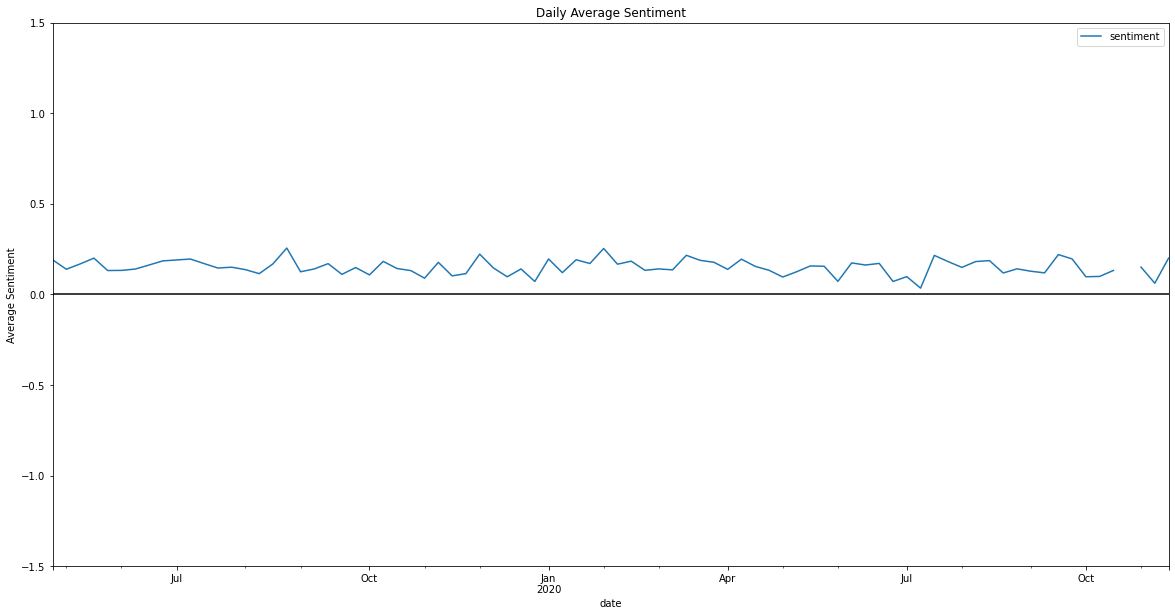

In [27]:
df_date_counts = TrumpFinal.groupby([pd.Grouper(key='date', freq='W-MON')]).mean().reset_index()
df_date_counts.plot(kind= 'line', x ='date', y = 'sentiment', figsize = (20,10), ylim = (-1.5,1.5))
plt.axhline(y=0, color = 'black')
plt.ylabel('Average Sentiment')
plt.title('Daily Average Sentiment')